I will use this notebook to talk through the process I have had to go through to get up and running on amls

* I have created a resource group
* I have created an AMLS workspace in the portal
* I have created a blob storage and placed it in the same resource group
* Using storage explorer I uploaded some data into this container i.e. the kaggle malware challenge data
* I have installed az shell on this machine
* I have installed azureml, azureml.core using pip on this machine
* installed AzureML data prep SDK with `pip install --upgrade azureml-dataprep`

In [7]:
from azureml.core import Workspace, Experiment, Run, Datastore
import math, random, pickle, json, os

We can load an azure machine learning "workspace" from a config.json file in the same folder, which is a file looking like this;

`
{
    "subscription_id": "a16914ac-dfcd-49d8-9a99-2be8cf06cbee",
    "resource_group": "openhack-lite",
    "workspace_name": "amls-oh-lite"
}
`

As you can see it definesd the subscription id, resource group and amls workspace name

In [3]:
ws = Workspace.from_config()

Found the config file in: C:\git\oh-lite\config.json
Performing interactive authentication. Please follow the instructions on the terminal.


Note, we have launched a browser for you to login. For old experience with device code, use "az login --use-device-code"
You have logged in. Now let us find all the subscriptions to which you have access...


Interactive authentication successfully completed.


So the first time around, we need to "register" a "data store" in azure machine learning. We can use blob, filestore, ADSL etc (see https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-access-data)

Looks like you can access blobs using SAS or key, and even create the container(?) if it doesn't already exist. 

In [35]:
ds = Datastore.register_azure_blob_container(workspace=ws, 
                                             datastore_name='ohlitestorage', 
                                             container_name='data',
                                             account_name='ohlitestorage', 
                                             account_key=os.getenv('OHLITESTORAGEKEY'),
                                             create_if_not_exists=True)

The second time around, you would access this data store using its name i.e. this:

In [36]:
ds = Datastore.get(ws, datastore_name='ohlitestorage')

We can enumerate all the data stored registered in this amls workspace;

There are a couple of default data stores which seem to have been pre-registered

In [39]:
#list all datastores registered in current workspace
datastores = ws.datastores
for name, ds in datastores.items():
    print(name, ds.datastore_type)

workspaceblobstore AzureBlob
workspacefilestore AzureFile
ohlitestorage AzureBlob


We can also set a default data store for this workspace, so let's set our one to be the default. 

In [41]:
ws.set_default_datastore('ohlitestorage')

We can download, upload data and even mount it depending on the execution context, presumably the aim with azmls is to support hetrogeneous computation contexts.

When we mount, it returns an environmental variable (?) giving the mount path. Mount only works in the azureml hosted compute environment

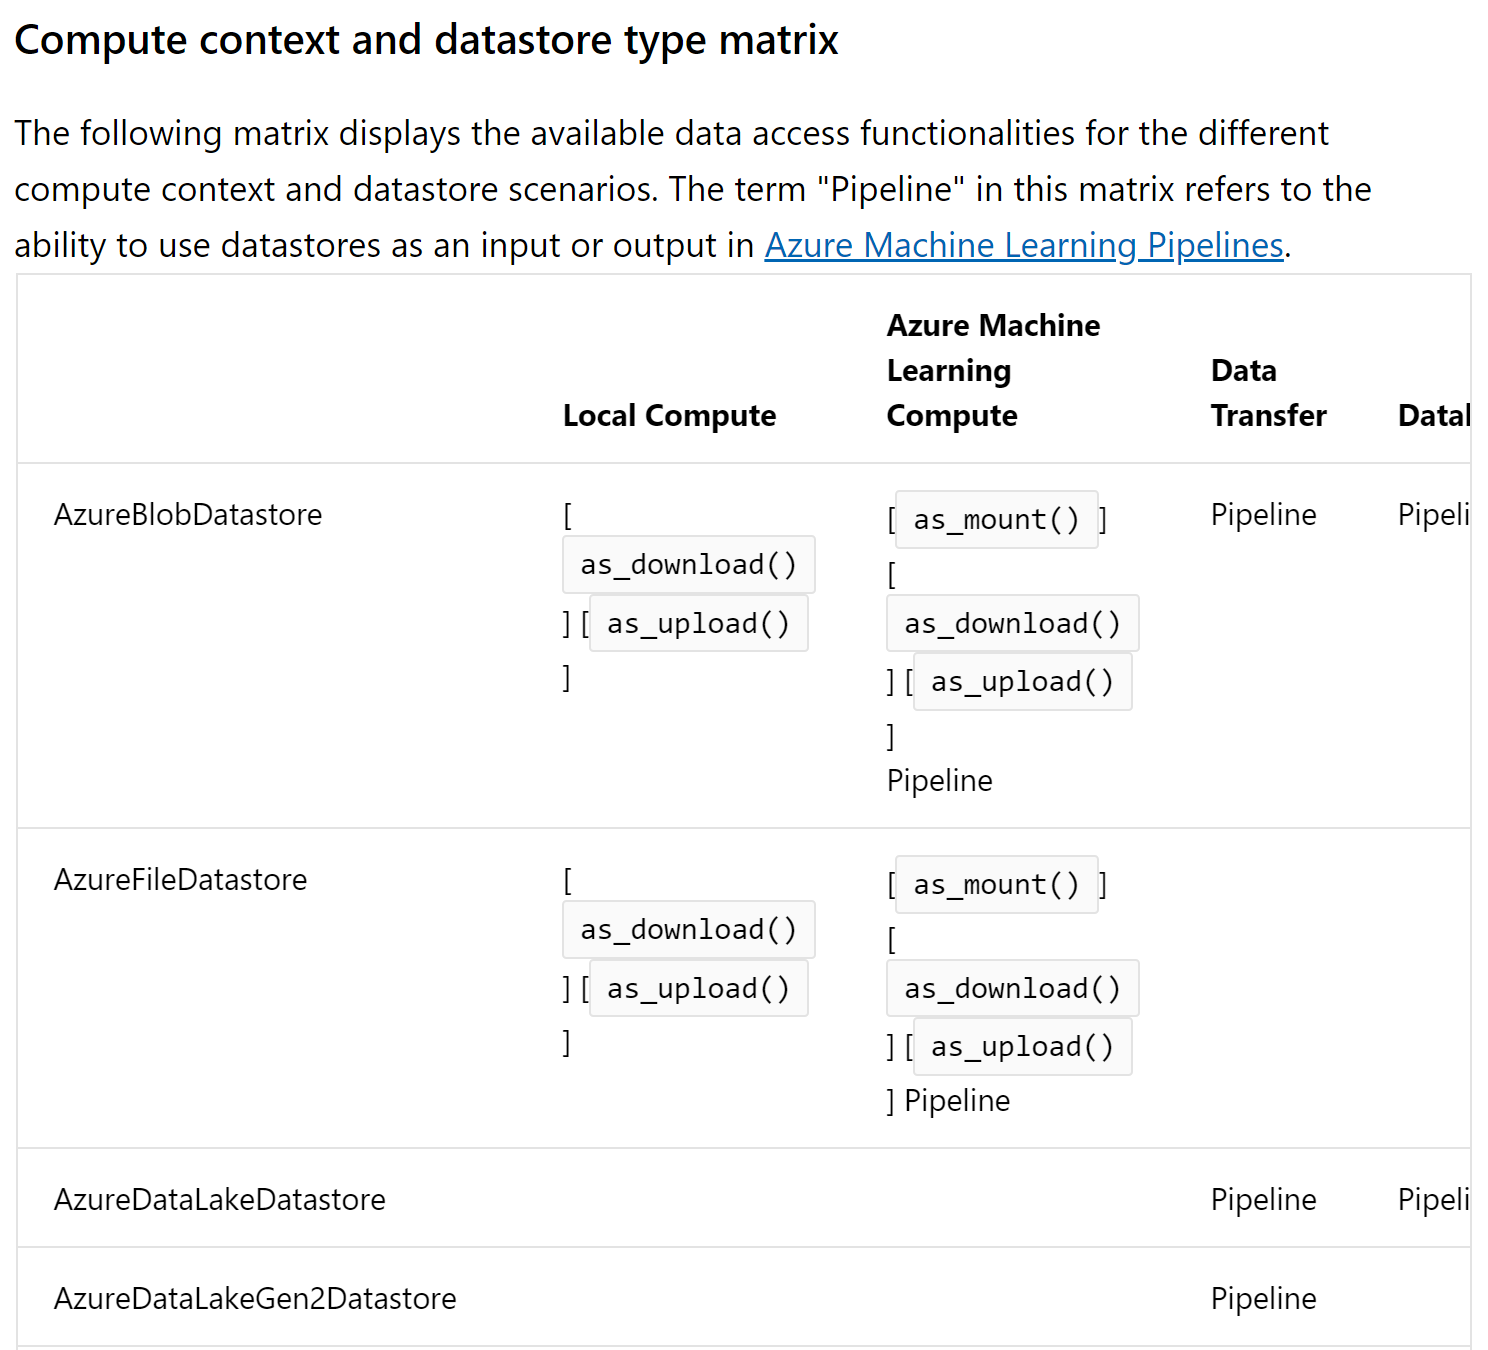

Thinking out loud, the only reason to use this data store feature in AML therefore is when doing things in a pipeline or azureml compute, useless for local computation

Let's try doing some stuff to our train.csv from the kaggle dataset with the azure data prep SDK

In [57]:
import azureml.dataprep as v

There is a feature to "auto read" the file and figure out the encoding etc. Of particular note is this executed much faster than Pandas takes to load the file but I assume that it hasn't actually loaded the entire file as this is some kind of streaming data library

In [58]:
%%time
dflow = dprep.auto_read_file(path="train.csv")

In [69]:
dflow_sample = dflow.random_split(0.1)

OSError: [Errno 22] Invalid argument

There is a feature to get some summary statistics

In [66]:
%%time
dflow_sample.get_profile()

OSError: [Errno 22] Invalid argument

Reading the docs.. The data prep seems to give us;

A nice fluent style API. I assume the justification for this to exist over just using Pandas is that this uses a streaming architecture i.e. you 
don't need all data to be in memory at the same time, flows can be persisted to files, and support native hetergeneous execution i.e. hopefully on 
a Spark context it will use Spark

I can see from the task manager that this library seems to be running on .NET and not utilizing more than one core at least on my machine context here

* Summary statistics
* Mutate/split column by example
* Assertions and filtering out errors from these assertions
* Replace nulls/nas
* Rename/Select columns
* Head
* Convert types
* Filtering
* Replacements

Of course the obvious thing we have to do in machine learning is normalisation and encoding, can't see anything in the tutorials to do that? I can see stuff in the API reference. Of course on this challenge we can't one-hot encode the categories because there are too many.

Slightly struggling to think of a reason to use this library over the standard open source libraries. Apart from anything else, there is zero documentation and no examples online whatsoever of people using this. The MinMaxScalerBuilder API seems onerous. Why would I use this?

In [63]:
dprep.api.builders.MinMaxScalerBuilder(dflow, )

TypeError: __init__() missing 7 required positional arguments: 'dataflow', 'engine_api', 'column', 'range_min', 'range_max', 'data_min', and 'data_max'

In [ ]:
experiment_name = "my-first-experiment"
run = list(Experiment(workspace = ws, name = experiment_name).get_runs())[0]